# Laboratory Practice 5 - Inference Foundations & Computational Simulation

- *Introduction to Statistical Computing*
- Author: Elena Conderana & Sergio Cuenca
- Date: 26/02/2025

This lab is to be done outside of class time. You may collaborate with one classmate, but you must identify yourself and his/her name above, in the author's field, and you must submit **your own** lab as this completed *.ipynb* file. 

Remember to always maintain good programming style by using clear variable names, commenting the code, creating useful, well-formatted graphs with appropriate titles and labels...

The sections of this notebook are listed below: 

1. [Load libraries](#libraries)
2. [Data](#data)
3. [Sampling distribution](#samplingdistribution)
4. [Confidence measures](#confidence)
5. [Computational Simulation](#computational)

----------------------

## 1. Load libraries <a id="libraries"></a>

Let's load in the following cell all the necessary libraries to complete this laboratory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 2. Data <a id="data"></a>

We consider real estate data from the city of Ames, Iowa. The details of every real estate transaction in Ames is recorded by the City Assessor's office. Our particular focus for this lab will be all residential home sales in Ames between 2006 and 2010.  This collection represents our population of interest. In this lab we would like to learn about these home sales by taking smaller samples from the full population. Let's load the data.

We begin by loading the `ames_housing` data frame:

In [2]:
# Load the dataset
ames_housing = pd.read_csv('Ames_Housing_Data.csv')
ames_housing.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


We see that there are quite a few variables in the data set, enough to do a very in-depth analysis. You can take a look to all variables and their meaning here: https://www.kaggle.com/datasets/ahmedmohameddawoud/ames-housing-data 

For this lab, we'll restrict our attention to just two of the variables: the above ground living area of the house in square feet (`Gr Liv Area`) and the sale price (`SalePrice`). Let's rename them as `area` and `price` for clarity.

In [3]:
# Rename the relevant columns
df = ames_housing[['Gr Liv Area', 'SalePrice']].rename(columns = {'Gr Liv Area': 'area', 'SalePrice': 'price'})
df.head()

,area,price
0,1656,215000
1,896,105000
2,1329,172000
3,2110,244000
4,1629,189900


## 3. Sampling Distribution <a id="samplingdistribution"></a>

We can explore the distribution of areas of homes in the population of home sales visually and with summary statistics. Let's first create a visualization, a histogram:

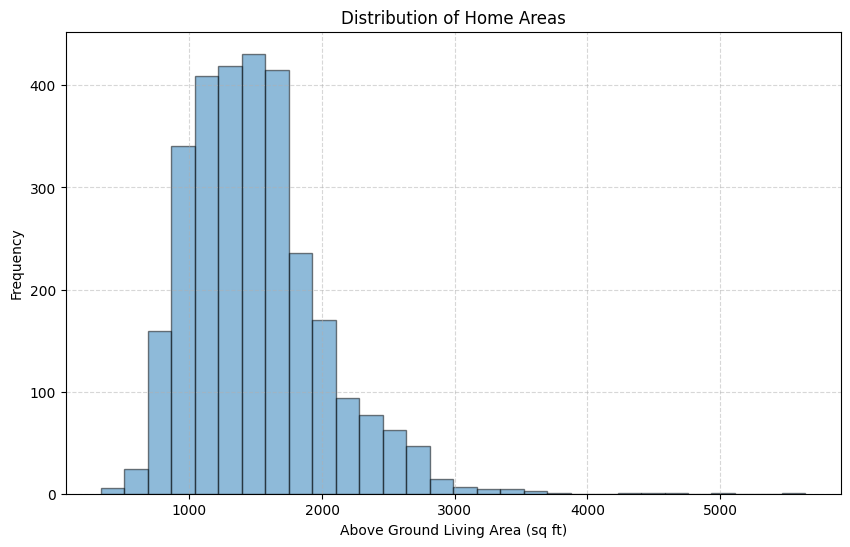

In [4]:
# Histogram of 'area'
plt.figure(figsize = (10, 6))
plt.hist(df['area'], bins = 30, edgecolor='black', alpha = 0.5)
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Frequency')
plt.title('Distribution of Home Areas')
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

Let's also obtain some summary statistics. Note that we can do this using the `agg` function from Pandas (in R this would be the function `summarise` from the dplyr package). We can calculate as many statistics as we want using this function, and store them in a dictionary with the results. Some of the functions should be self explanatory (like `mean`, `median`, `sd`, `IQR`, `min`, and `max`). A new function here is the `quantile` function which we can use to calculate values corresponding to specific percentile cutoffs in the distribution. For example `quantile(0.25)` will yield the cutoff value for the 25th percentile (Q1) in the distribution of x. Finding these values are useful for describing the distribution, as we can use them for descriptions like *"the middle 50% of the homes have areas between such and such square feet"*.

In [5]:
# Summary statistics
summary_stats = df['area'].agg({
    'mean': 'mean',
    'median': 'median',
    'std_dev': 'std',
    'IQR': lambda x: x.quantile(0.75) - x.quantile(0.25),
    'min': 'min',
    'Q1': lambda x: x.quantile(0.25),
    'Q3': lambda x: x.quantile(0.75),
    'max': 'max'
})

In [6]:
# Print summary statistics
print(summary_stats)

mean       1499.690444
median     1442.000000
std_dev     505.508887
IQR         616.750000
min         334.000000
Q1         1126.000000
Q3         1742.750000
max        5642.000000
Name: area, dtype: float64


a) Which of the following is **false**:
- The distribution of areas of houses in Ames is unimodal and right-skewed.
- 50\% of houses in Ames are smaller than 1,499.69 square feet.
- The middle 50\% of the houses range between approximately 1,126 square feet and 1,742.7 square feet.
- The IQR is approximately 616.7 square feet.
- The smallest house is 334 square feet and the largest is 5,642 square feet.

**Answer:** 50\% of houses in Ames are smaller than 1,499.69 square feet. 50% of houses are smaller than the median (1,442 sq ft), not the mean (1,499.69 sq ft).

### 3.1 The unknown sampling distribution

In this lab we have access to the entire population, but this is rarely the case in real life. Gathering information on an entire population is often extremely costly or impossible. Because of this, we often take a sample of the population and use that to understand the properties of the population.

If we were interested in estimating the mean living area in Ames based on a sample, we can use the following command to survey the population.

In [7]:
samp1 = ames_housing.sample(n = 50, random_state = 42)  # random_state ensures reproducibility
samp1

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1357,903427090,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000
2367,527450460,160,RM,21.0,1890,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,116000
2822,908128100,60,RL,62.0,7162,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,196500
2126,907135180,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600
1544,910200080,30,RM,50.0,7000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,126000
2415,528221010,20,RL,102.0,11660,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,174190
2227,909455060,120,RM,35.0,3907,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,200000
410,527453060,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,148500
761,904100190,20,RL,50.0,4280,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,88750
436,528118060,60,RL,59.0,23303,Pave,NaN,IR3,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Family,409900


This command collects a simple random sample of `size` 50 from the `ames` dataset, which is assigned to `samp1`. This is like going into the City Assessor's database and pulling up the files on 50 random home sales. Working with these 50 files would be considerably simpler than working with all 2930 home sales.

b) Describe the distribution of this sample. How does it compare to the distribution of the population? 

**Hint:** `sample(n=x)` function takes a random sample of observations (i.e. rows) from the dataset, you can still refer to the variables in the dataset with the same names. Code you used in the previous exercise will also be helpful for visualizing and summarizing the sample, however be careful to not label values `mu` and `sigma` anymore since these are sample statistics, not population parameters. You can customize the labels of any of the statistics to indicate that these come from the sample.

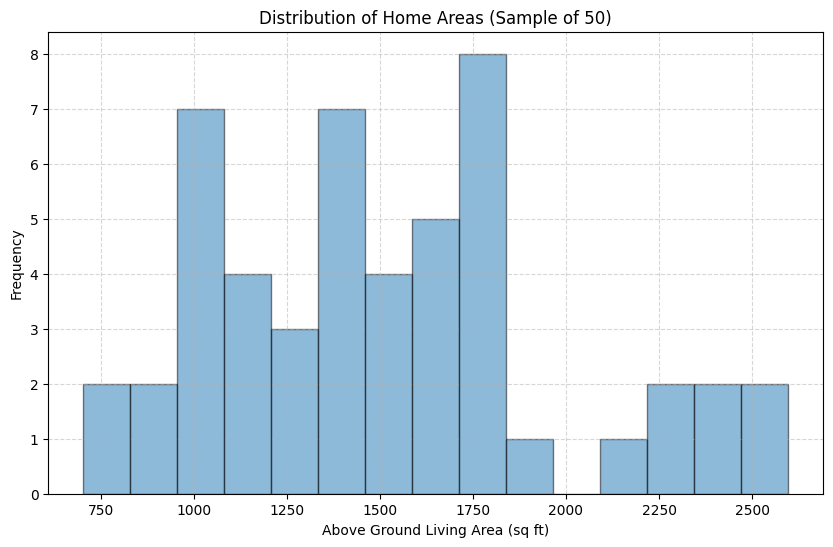

In [8]:
samp1 = df.sample(n = 50, random_state = 42)

# Sample Histogram
plt.figure(figsize = (10, 6))
plt.hist(samp1['area'], bins = 15, edgecolor = 'black', alpha = 0.5)
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Frequency')
plt.title('Distribution of Home Areas (Sample of 50)')
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

In [9]:
# Sample Statistics
sample_stats = samp1['area'].agg({
    'sample_mean': 'mean',
    'sample_median': 'median',
    'sample_std_dev': 'std',
    'sample_IQR': lambda x: x.quantile(0.75) - x.quantile(0.25),
    'sample_min': 'min',
    'sample_Q1': lambda x: x.quantile(0.25),
    'sample_Q3': lambda x: x.quantile(0.75),
    'sample_max': 'max'
})

print(sample_stats)

sample_mean       1519.260000
sample_median     1461.000000
sample_std_dev     462.529373
sample_IQR         658.750000
sample_min         704.000000
sample_Q1         1102.250000
sample_Q3         1761.000000
sample_max        2596.000000
Name: area, dtype: float64


**Answer:**
- The population distribution is right-skewed, with a long tail extending toward larger home sizes. On the other hand, the sample distribution roughly follows this shape but appears less smooth and more irregular due to the smaller number of observations.
- The sample mean is slightly higher than the population mean, but they are fairly close, showing that the sample is a reasonable representation.
- The sample variability is slightly lower, likely because extreme values are missing in a smaller sample.

If we're interested in estimating the average living area in homes in Ames using the sample, our best single guess is the sample mean.

**Answer:** Mean value for sample 1 with 50 transactions is: 1519.26

Depending on which 50 homes you selected, your estimate could be a bit above or a bit below the true population mean of 1,499.69 square feet. In general, though, the sample mean turns out to be a pretty good estimate of the average living area, and we were able to get it by sampling less than 3\% of the population.


c) Suppose we took two more samples, one of size 100 and one of size 1000. Which would you think would provide a more accurate estimate of the population mean?
- Sample size of 50.
- Sample size of 100.
- Sample size of 1000.

**Answer:** As the sample size increases, the sample mean tends to get closer to the population mean due to the Law of Large Numbers. Therefore, a sample size of 1000 would provide a more accurate estimate of the population mean. A larger sample size reduces variability and improves precision when estimating population parameters. Sampling error decreases with a larger sample, meaning the mean of a sample of 1000 will be much closer to the true population mean compared to samples of 50 or 100.

Let's take one more sample of size 50, and view the mean area in this sample:

In [10]:
samp2 = df.sample(n = 50, random_state = 43)
mean_samp2 = samp2['area'].agg({ 'sample_mean': 'mean'})

print(mean_samp2)

sample_mean    1458.44
Name: area, dtype: float64


Not surprisingly, every time we take another random sample, we get a different sample mean. It's useful to get a sense of just how much variability we should expect when estimating the population mean this way. The distribution of sample means, called the *sampling distribution*, can help us understand this variability. 

In this lab, because we have access to the population, we can build up the sampling distribution for the sample mean by repeating the above steps many times. Here we will generate 15,000 samples and compute the sample mean of each. Note that we are sampling with replacement, `replace = TRUE` since sampling distributions are constructed with sampling with replacement.

Here we take 15,000 samples of size 50 from the population, calculate the mean of each sample, and store each result in a df called `sample_means50_df`.

In [11]:
# Set the number of samples
num_samples = 15000
sample_size = 50

# Generate the sampling distribution
sampling_means = [df['area'].sample(n = sample_size, replace = True).mean() for _ in range(num_samples)]

# Convert to a DataFrame
sample_means50_df = pd.DataFrame(sampling_means, columns = ['sample_mean'])

# Display the first few rows
sample_means50_df.head()

,sample_mean
0,1463.66
1,1493.18
2,1522.16
3,1384.86
4,1598.74


d) How many elements are there in `sample_means50`?  Describe the sampling distribution. Are the mean and spread values expected? Make sure to include a plot of the distribution in your answer and mention which theorem ensures its shape.

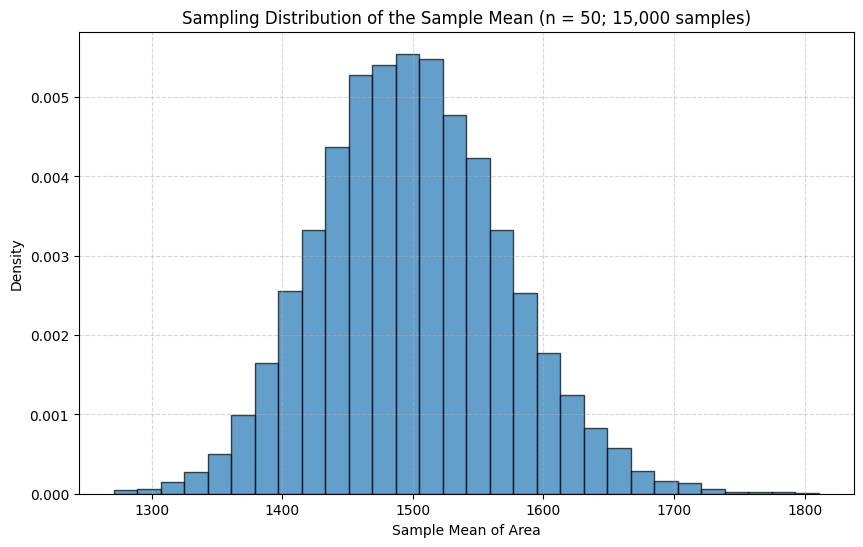

15000


In [12]:
# Number of elements in sampling_distribution
num_elements = len(sample_means50_df)

# Plot the sampling distribution
plt.figure(figsize = (10, 6))
plt.hist(sample_means50_df['sample_mean'], bins=30, edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Sample Mean of Area')
plt.ylabel('Density')
plt.title('Sampling Distribution of the Sample Mean (n = 50; 15,000 samples)')
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

print(num_elements)

In [13]:
# Summary statistics
sampling_stats = sample_means50_df['sample_mean'].agg({
    'mean': 'mean',
    'std_dev': 'std',
    'min': 'min',
    'Q1': lambda x: x.quantile(0.25),
    'median': 'median',
    'Q3': lambda x: x.quantile(0.75),
    'max': 'max'
})

print(sampling_stats)

mean       1499.815399
std_dev      70.896302
min        1271.200000
Q1         1451.000000
median     1497.580000
Q3         1546.060000
max        1810.620000
Name: sample_mean, dtype: float64


**Answer:** The dataset contains $15,000$ elements. The histogram of the sampling distribution is bell-shaped and follows a normal distribution, as expected by the Central Limit Theorem. The CLT states that the distribution of the sample mean will be approximately normal, regardless of the population's original distribution, as long as the sample size is sufficiently large ($n ≥ 30$).

The mean of the sampling distribution ($1,500.85$) is approximately equal to the population mean ($1,499.69$), while the spread is smaller than the population standard deviation. The spread of the sampling distribution is expected to be smaller than the population standard deviation because the standard error of the mean decreases as the sample size increases.

### 3.2 Interlude: Sampling distributions

The idea behind the `sample` function with replacement is *repetition*. Earlier we took a single sample of size `n` (50) from the population of all houses in Ames. With this new function we are able to repeat this sampling procedure `rep` times in order to build a distribution of a series of sample statistics, which is called the **sampling distribution**. 

Note that in practice one rarely gets to build sampling distributions, because we rarely have access to data from the entire population. 

In R, the function `rep_sample_n` allows us to repeat the sampling procedure efficiently. The equivalent in Python would be using the `pandas.DataFrame.sample()` method within a loop, combined with a custom function to repeat the process multiple times.

e) To make sure you understand how sampling distributions are built, build a function with three input arguments to create a sampling distribution of **25 sample means** from **samples of size 10**, and put them in a data frame named `sample_means_small`. Print the output. How many observations are there in this object called `sample_means_small`? What does each observation represent?

In [14]:
# Function to generate sample means
def generate_sample_means(data, sample_size, num_samples):
    sample_means = [data.sample(n = sample_size, replace = True).mean() for _ in range(num_samples)]
    return pd.DataFrame(sample_means, columns = ['sample_mean'])

# Generate the sampling distribution with 25 sample means from samples of size 10
sample_means_small = generate_sample_means(df['area'], sample_size = 10, num_samples = 25)

# Print the output
print(sample_means_small)

# Number of observations in sample_means_small
print(f"Number of observations: {len(sample_means_small)}")

    sample_mean
0        1497.4
1        1520.7
2        1585.4
3        1628.9
4        1148.7
5        1506.2
6        1477.6
7        1635.2
8        1249.0
9        1345.9
10       1365.4
11       1465.7
12       1433.2
13       1548.6
14       1428.2
15       1389.7
16       1590.4
17       1368.6
18       1499.1
19       1501.3
20       1491.5
21       1479.7
22       1655.7
23       1564.5
24       1442.5
Number of observations: 25


f) How many elements are there in this object called `sample_means_small`? 
- 1
- 3
- 10
- 25
- 100
- 1,000

**Answer:** 25

g) Which of the following is **true** about the elements in the sampling distributions you created?
- Each element represents a mean square footage from a simple random sample of 10 houses.
- Each element represents the square footage of a house.
- Each element represents the true population mean of square footage of houses.

**Answer:** Each element represents a mean square footage from a simple random sample of 10 houses.

### 3.3 Sample size and the sampling distribution

Mechanics aside, let's return to the reason we used the `sample` function within a loop: to compute a sampling distribution, specifically, this one.

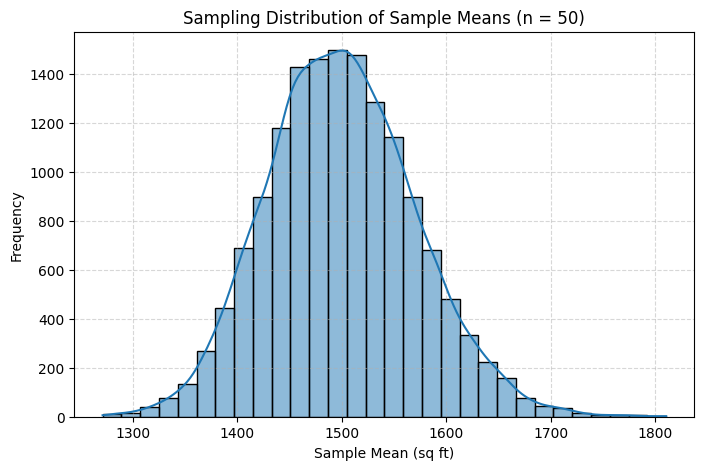

In [15]:
# Histogram from question d 
plt.figure(figsize = (8, 5))
sns.histplot(sample_means50_df["sample_mean"], bins = 30, kde = True, edgecolor = "black", alpha = 0.5)
plt.xlabel("Sample Mean (sq ft)")
plt.ylabel("Frequency")
plt.title("Sampling Distribution of Sample Means (n = 50)")
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

The sampling distribution that we computed tells us much about estimating the average living area in homes in Ames.  Because the sample mean is an unbiased estimator, the sampling distribution is centered at the true average living area of the population, and the spread of the distribution indicates how much variability is induced by sampling only 50 home sales.

In the remainder of this section we will work on getting a sense of the effect that sample size has on our sampling distribution.

h) Use the function below to create sampling distributions of means of `area` from samples of size 10, 50, 100 and 1,000 and plot them in an histogram. Use 5,000 simulations. What does each observation in the sampling distribution represent? How does the mean, standard error, and shape of the sampling distribution change as the sample size increases? How (if at all) do these values change if you increase the number of simulations?

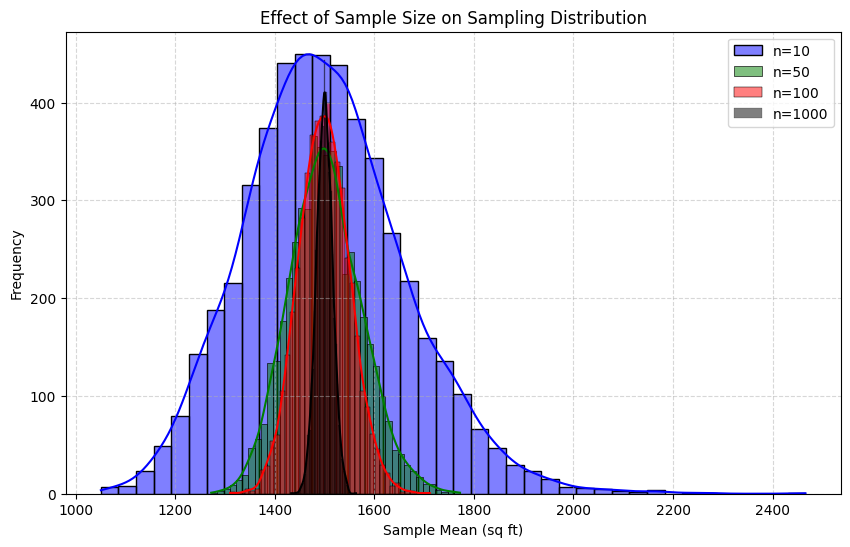

In [16]:
def generate_sampling_distribution(sample_size, num_samples):
    return [
        df["area"].sample(n = sample_size, replace = True).mean()
        for _ in range(num_samples)
    ]

# Generate distributions
num_samples = 5000
sampling_dist_10 = generate_sampling_distribution(10, num_samples)
sampling_dist_50 = generate_sampling_distribution(50, num_samples)
sampling_dist_100 = generate_sampling_distribution(100, num_samples)
sampling_dist_1000 = generate_sampling_distribution(1000, num_samples)


# Plot distributions
plt.figure(figsize = (10, 6))
sns.histplot(sampling_dist_10, bins = 40, kde = True, color = "blue", alpha = 0.5, label = "n=10")
sns.histplot(sampling_dist_50, bins = 40, kde = True, color = "green", alpha = 0.5, label = "n=50")
sns.histplot(sampling_dist_100, bins = 40, kde = True, color = "red", alpha = 0.5, label = "n=100")
sns.histplot(sampling_dist_1000, bins = 40, kde = True, color = "black", alpha = 0.5, label = "n=1000")
plt.xlabel("Sample Mean (sq ft)")
plt.ylabel("Frequency")
plt.title("Effect of Sample Size on Sampling Distribution")
plt.grid(linestyle = '--', alpha = 0.5)
plt.legend()
plt.show()


**Answer:**
- Each observation in the sampling distribution represents the mean of a random sample of houses (with replacement) from the Ames housing dataset.
- As the sample size increases, the mean of the sampling distribution gets closer to the population mean, while the standard error decreases. This can be verified by the Standard Error formula: $$SE = \frac{\sigma}{\sqrt{n}}$$ The shape of the sampling distribution becomes more normal as the sample size increases, following the CLT.
- Increasing the number of simulations does not affect the mean or standard error of the sampling distribution, but it can improve the precision of the estimates and reduce variability.

i)  It makes intuitive sense that as the sample size increases, the center of the sampling distribution becomes a more reliable estimate for the true population mean. Also as the sample size increases, the variability of the sampling distribution ________: 
- Decreases. 
- Increases. 
- Stays the same.

**Answer:** Decreases.

j) Take a random sample of size 20 from `price`. Using this sample, what is your best point estimate of the population mean?

In [17]:
sample_price = df['price'].sample(n = 20, random_state = 42)
point_estimate = sample_price.mean()

# Print the point estimate
print(f"Best point estimate of the population mean: {point_estimate}")

Best point estimate of the population mean: 165667.0


k) Since you have access to the population, simulate the sampling distribution for $\bar{x}_{price}$ by taking 5000 samples from the population of size 20 and computing 5000 sample means.  Store these means in a vector called `sample_means20`. Plot the data, then describe the shape of this sampling distribution. Based on this sampling distribution, what would you guess the mean home price of the population to be?

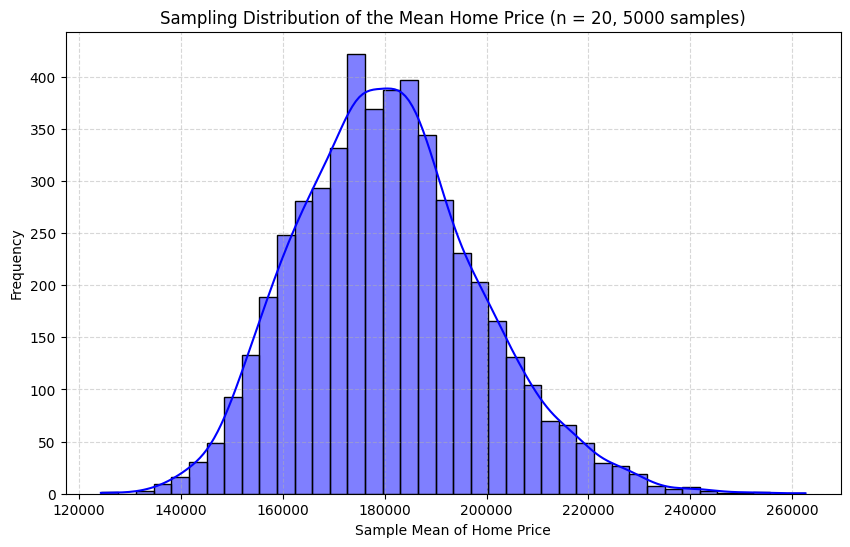

In [18]:
num_samples = 5000
sample_size = 20

sample_means20 = [
    df['price'].sample(n = sample_size, replace = True).mean() for _ in range(num_samples)
]

sample_means20_df = pd.DataFrame(sample_means20, columns = ['sample_mean'])

# Plot the sampling distribution
plt.figure(figsize = (10, 6))
sns.histplot(sample_means20_df['sample_mean'], bins = 40, kde = True, color = "blue", alpha = 0.5)
plt.xlabel("Sample Mean of Home Price")
plt.ylabel("Frequency")
plt.title("Sampling Distribution of the Mean Home Price (n = 20, 5000 samples)")
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

In [19]:
estimated_population_means20 = sample_means20_df['sample_mean'].mean()
estimated_population_means20

180750.20337

**Answer:** The sampling distribution of the mean home price appears to be approximately normal, following the CLT, though it has some right skew. The slight right skew is likely due to outliers in the housing prices, where some homes have significantly higher prices than the majority. The mean of the population distribution must be around $180,000$. If the sample size were larger, the distribution would become even more normal and symmetric, and the standard error would decrease, improving precision.


l) Change your sample size from 20 to 150, then compute the sampling distribution using the same method as above, and store these means in a new vector called `sample_means150`. Describe the shape of this sampling distribution, and compare it to the sampling distribution for a sample size of 20 by plotting both of them together. Based on this sampling distribution, what would you guess to be the mean sale price of homes in Ames?

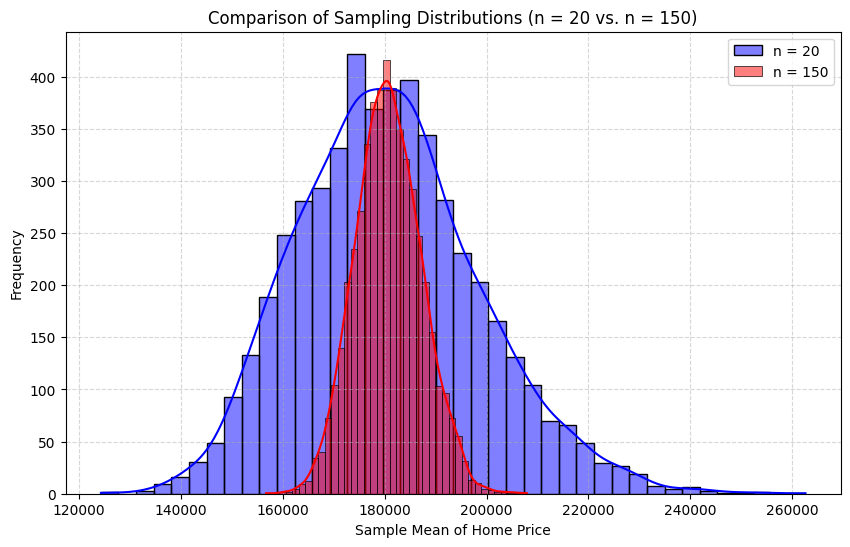

In [20]:
num_samples = 5000
sample_size = 150

sample_means150 = [
    df['price'].sample(n = sample_size, replace = True).mean() for _ in range(num_samples)
]

sample_means150_df = pd.DataFrame(sample_means150, columns = ['sample_mean'])

# Plot the sampling distribution
plt.figure(figsize = (10, 6))
sns.histplot(sample_means20_df['sample_mean'], bins = 40, kde = True, color = "blue", alpha = 0.5, label = "n = 20")
sns.histplot(sample_means150_df['sample_mean'], bins = 40, kde = True, color = "red", alpha = 0.5, label = "n = 150")
plt.xlabel("Sample Mean of Home Price")
plt.ylabel("Frequency")
plt.title("Comparison of Sampling Distributions (n = 20 vs. n = 150)")
plt.grid(linestyle = '--', alpha = 0.5)
plt.legend()
plt.show()

In [21]:
estimated_population_means150 = sample_means150_df['sample_mean'].mean()
estimated_population_means150

180753.32642133333

**Answer:** The sampling distribution of the mean home price for a sample size of 150 is more normal and symmetric compared to the distribution for a sample size of 20. It maintains a bell-shaped normal distribution, again  expected from the CLT. The standard error is smaller, and the mean of the sampling distribution is also smaller and near $180,000$. The mean sale price of homes in Ames is likely around this value.

m) Which of the following is **false**?
- The variability of the sampling distribution with the smaller sample size (`sample_means20`) is smaller than the variability of the sampling distribution with the larger sample size (`sample_means150`).
- The means for the two sampling distribtuions are roughly similar.
- Both sampling distributions are symmetric.

**Answer:** The variability of the sampling distribution with the smaller sample size (`sample_means20`) is smaller than the variability of the sampling distribution with the larger sample size (`sample_means150`). Smaller sample sizes have greater variability, not less.

## 4. Confidence measures <a id="confidence"></a>

If you have access to data on an entire population, say the size of every house in Ames, Iowa, it's straight forward to answer questions like, "How big is the typical house in Ames?" and "How much variation is there in sizes of houses?". If you have access to only a sample of the population, as is often the case, the task becomes more complicated. What is your best guess for the typical size if you only know the sizes of several dozen houses? This sort of situation requires that you use your sample to make inference on what your population looks like.

We will take some random samples and calculate confidence based on these samples in this lab, which means you should set a seed on top of your lab.

Setting a seed will cause python to sample the same sample each time you run the cell. This will make sure your results don't change each time, and it will also ensure reproducibility of your work (by setting the same seed it will be possible to reproduce your results). You can set a seed like this:

In [22]:
# Set seed
np.random.seed(9102015)

The number above is completely arbitrary. If you need inspiration, you can use yourID, birthday, or just a random string of numbers. The important thing is that you use each seed only once. You only need to do this once in your notebook, but make sure it comes before sampling.

For the following exercises, we will need a sample of 60 transactions: 

In [23]:
# Selecting a 60 sample
sample_60 = df["area"].sample(n = 60)
sample_60.describe()

count      60.000000
mean     1505.800000
std       475.933616
min       698.000000
25%      1168.750000
50%      1434.000000
75%      1768.000000
max      2730.000000
Name: area, dtype: float64

a) True or False: My distribution should be similar to others' distributions who also collect random samples from this population, but it is likely not exactly the same since it's a random sample.

**Answer:** True. Although the distribution of each random sample drawn from the same population is generally comparable to that of the entire population, sampling is random, thus each sample may still exhibit variance.

### 4.1 Confidence intervals

Return for a moment to the question that first motivated this lab: based on this sample, what can we infer about the population? Based only on a single sample, the best estimate of the average living area of houses sold in Ames would be the sample mean, usually denoted as $\bar{x}$ (here we're calling it `x_bar`). That serves as a good **point estimate** but it would be useful to also communicate how uncertain we are of that estimate. This uncertainty can be quantified using a **confidence interval**.

A confidence interval for a population mean is of the following form: $\bar{x} \pm z^\star \frac{s}{\sqrt{n}}$ 

You should by now be comfortable with calculating the mean and standard deviation of a sample in python. And we know that the sample size is 60. So the only remaining building block is finding the appropriate critical value for a given confidence level. We can use the `norm.ppf` function (library scipy.stats) for this task, which will give the critical value associated with a given percentile under the normal distribution. Remember that confidence levels and percentiles are not equivalent. For example, a 95% confidence level refers to the middle 95% of the distribution, and the critical value associated with this area will correspond to the 97.5th percentile.

b) Calculate the confidence interval for 95%:

In [24]:
from scipy.stats import norm

x_bar = np.mean(sample_60)
s = np.std(sample_60, ddof=1)
n = len(sample_60)

# Confidence level to percentile conversion
confidence_level = 0.95
z_star = norm.ppf(1 - (1 - confidence_level) / 2)

# Get the margin of error
margin_of_error = z_star * (s / np.sqrt(n))

# Get the confidence interval
lower_bound = x_bar - margin_of_error
upper_bound = x_bar + margin_of_error

(lower_bound, upper_bound)

(1385.3743922855335, 1626.2256077144664)

*To recap*: even though we don't know what the full population looks like, we're 95% confident that the true average size of houses in Ames lies between the values *lower* and *upper*. There are a few conditions that must be met for this interval to be valid.

c) For the confidence interval to be valid, the sample mean must be normally distributed and have standard error $s / \sqrt{n}$. Which of the following is not a condition needed for this to be true?
- The sample is random.
- The sample size, 60, is less than 10% of all houses.
- The sample distribution must be nearly normal.

**Answer:** The sample size, 60, is less than 10% of all houses. Assuming random sampling, which should support the distribution's normality via the CLT, this condition focuses more on guaranteeing the independence of the sample points than it does on directly affecting the distribution of the sample mean. As a result, it is more relevant to the general principles of probability sampling than it is to the validity of the normal approximation of the sample mean.

### 4.2 Confidence levels

d) What does "95% confidence" mean?
- 95% of the time the true average area of houses in Ames, Iowa, will be in this interval.
- 5% of random samples of size 60 will yield confidence intervals that contain the true average area of houses in Ames, Iowa.
- 95% of the houses in Ames have an area in this interval.
- 95% confident that the sample mean is in this interval.

**Answer:** 95% of the time the true average area of houses in Ames, Iowa, will be in this interval. We can be 95% confident that this method of interval calculation will capture the true population mean if we were to use it repeatedly across multiple samples.

e) In this case we have the rare luxury of knowing the true population mean since we have data on the entire population. Let's calculate this value so that we can determine if our confidence intervals actually capture it. Does your confidence interval capture the true average size of houses in Ames?

In [25]:
# Get true population mean
true_population_mean = df['area'].mean()
true_population_mean

1499.6904436860068

In [26]:
# Check if CI contains the true mean
if lower_bound <= true_population_mean <= upper_bound:
    print("The true population mean is within the confidence interval.")
else:
    print("The true population mean is not within the confidence interval.")

The true population mean is within the confidence interval.


f) What proportion of 95% confidence intervals would you expect to capture the true population mean?
- 1%
- 5%
- 95%
- 99%

**Answer:** 95%. It indicates that if you were to take many random samples from the population and calculate a 95% confidence interval from each one, approximately 95% of those intervals would be expected to contain the true population mean.

We're going to collect many samples to learn more about how sample means and confidence intervals vary from one sample to another. Here is the rough outline:
1) Obtain a random sample.
2) Calculate the sample's mean and standard deviation, and use these to calculate and store the lower and upper bounds of the confidence intervals.
3) Repeat these steps 50 times.

Therefore, the aim of this part is to build a dataset with two columns (lower and upper) where each row represents one of the 50 times values of the selected sample.

In [35]:
sample_means = []
sample_stds = []
lower_bounds = []
upper_bounds = []

num_samples = 50
sample_size = 60

# Confidence level for the z-score
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

for _ in range(num_samples):
    sample = df['area'].sample(n=sample_size, replace = False)
    sample_mean = sample.mean()
    sample_std = sample.std(ddof = 1)

    margin_of_error = z_score * (sample_std / np.sqrt(sample_size))

    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    sample_means.append(sample_mean)
    sample_stds.append(sample_std)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

results_df = pd.DataFrame({
    'Sample Mean': sample_means,
    'Sample Std Dev': sample_stds,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})

results_df[['Lower Bound', 'Upper Bound']].head()

,Lower Bound,Upper Bound
0,1288.977758,1521.522242
1,1357.680128,1560.253206
2,1342.690776,1704.709224
3,1352.497735,1570.435598
4,1415.675326,1663.724674


Next we'll create a plot similar to Figure 4.8 on page 175 of [OpenIntro Statistics, 3rd Edition](https://www.openintro.org/os). First step will be to create a new variable in the `ci` data frame that indicates whether the interval does or does not capture the true population mean. Note that capturing this value would mean the lower bound of the confidence interval is below the value and upper bound of the confidence interval is above the value. Remember that we create new variables using the `apply` function.

In [36]:
# Create new variable
ci = pd.DataFrame({
    'ci_id': list(range(1, 51)) * 2,
    'ci_bounds': results_df['Lower Bound'].tolist() + results_df['Upper Bound'].tolist(),
    'capture_mu': ['yes' if lb <= true_population_mean <= ub else 'no' 
                   for lb, ub in zip(results_df['Lower Bound'], results_df['Upper Bound'])] * 2
})

ci['Bound Type'] = ['Lower'] * 50 + ['Upper'] * 50
ci.sort_values(by = ['ci_id', 'Bound Type'], inplace = True)

We now have all the information we need to create the plot, but we need to re-organize our data a bit for easy plotting. Specifically, we need to organize the data in a new data frame where each row represents one bound, as opposed to one interval. So this: 
~~~
     lower    upper capture_mu
1 1350.540 1544.360        yes
2 1333.441 1584.425        yes
3 1412.133 1663.801        yes
...
~~~
should instead look like:
~~~
  ci_id ci_bounds capture_mu
1     1  1350.540        yes
2     2  1333.441        yes
3     3  1412.133        yes
4     1  1544.360        yes
5     2  1584.425        yes
6     3  1663.801        yes
...
~~~

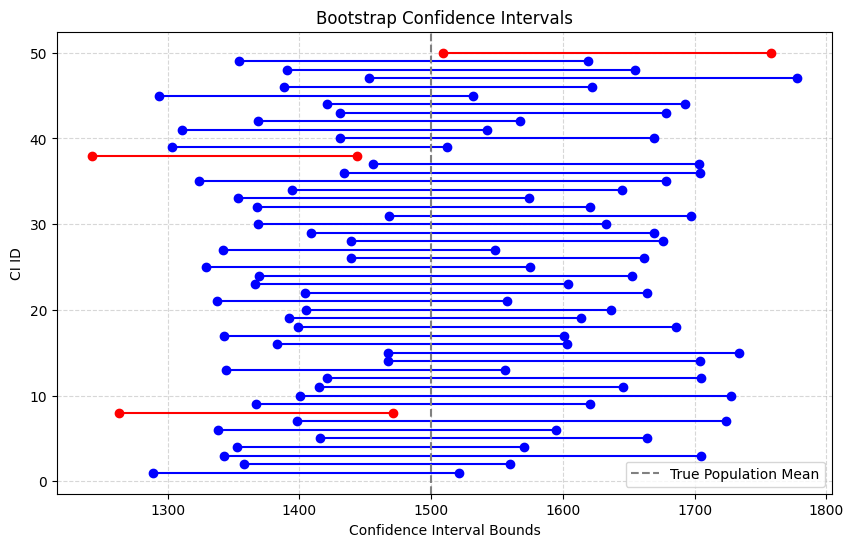

In [37]:
plt.figure(figsize = (10, 6))
for i in range(1, 51):
    sub_df = ci[ci['ci_id'] == i]
    plt.plot(sub_df['ci_bounds'], [i, i], marker='o', color='blue' if 'yes' in sub_df['capture_mu'].values else 'red')

# Marking the true population mean
plt.axvline(x=true_population_mean, color='gray', linestyle='--', label='True Population Mean')

plt.xlabel('Confidence Interval Bounds')
plt.ylabel('CI ID')
plt.title('Bootstrap Confidence Intervals')
plt.grid(linestyle = '--', alpha = 0.5)
plt.legend()
plt.show()

g) What proportion of your confidence intervals include the true population mean? Is this proportion exactly equal to the confidence level? If not, explain why.

In [38]:
unique_intervals = ci.drop_duplicates(subset = 'ci_id')

num_yes = unique_intervals['capture_mu'].value_counts().get('yes', 0)
total_intervals = len(unique_intervals)
proportion_capturing_mean = num_yes / total_intervals

print(f"Proportion of intervals capturing the true mean: {proportion_capturing_mean:.2f}")

Proportion of intervals capturing the true mean: 0.94


**Answer:** The proportion of intervals capturing the true mean is 94%, which is slightly below the expected 95% confidence level. This disparity can be explained by the limiting number of trials, statistical variability in random sampling, and any potential deviations from the statistical model's underlying presumptions, such as the normality of the data distribution.

h) What is the appropriate critical value for a 99% confidence level?
- 0.01
- 0.99
- 1.96
- 2.33
- 2.58

**Answer:** The appropriate critical value for a 99% confidence level is 2.58. This value corresponds to the z-score that captures the central 99% of a standard normal distribution, leaving 0.5% in each tail.

i) Calculate 50 confidence intervals at the 99% confidence level. You do not need to obtain new samples, simply calculate new intervals based on the 95% confidence interval endpoints you had already collected. Plot all intervals and calculate the proportion of intervals that include the true population mean.

In [39]:
# Critical value for 99% confidence
z_score_99 = 2.58

# Update the margin of error for each interval
results_df['99% Margin of Error'] = z_score_99 * (results_df['Sample Std Dev'] / np.sqrt(60))

# Calculate new bounds for the 99% confidence interval
results_df['99% Lower Bound'] = results_df['Sample Mean'] - results_df['99% Margin of Error']
results_df['99% Upper Bound'] = results_df['Sample Mean'] + results_df['99% Margin of Error']

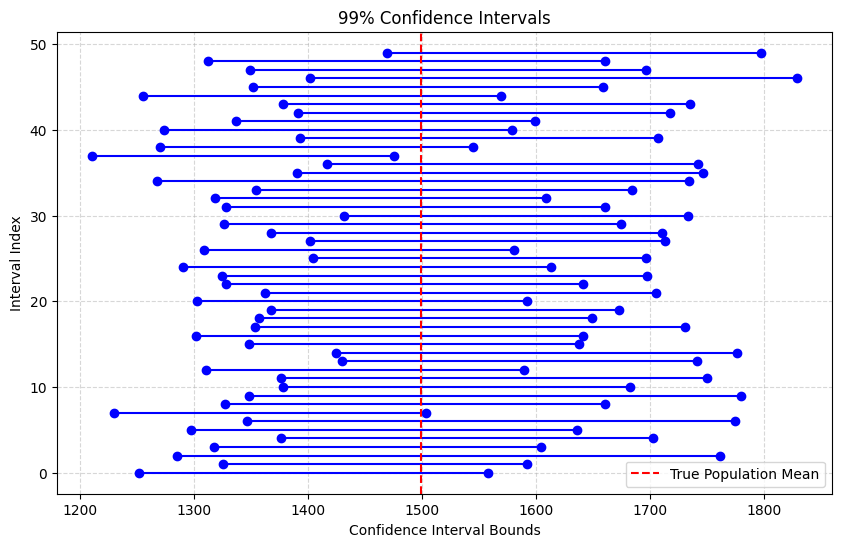

In [40]:
plt.figure(figsize = (10, 6))

for i in range(len(results_df)):
    plt.plot([results_df.loc[i, '99% Lower Bound'], results_df.loc[i, '99% Upper Bound']], [i, i], marker = 'o', color = 'blue')
plt.axvline(x = true_population_mean, color = 'red', linestyle = '--', label = 'True Population Mean')
plt.xlabel('Confidence Interval Bounds')
plt.ylabel('Interval Index')
plt.title('99% Confidence Intervals')
plt.grid(linestyle = '--', alpha = 0.5)
plt.legend()
plt.show()

In [41]:
results_df['99% Captures Mean'] = (results_df['99% Lower Bound'] <= true_population_mean) & (results_df['99% Upper Bound'] >= true_population_mean)
proportion_capturing_mean_99 = results_df['99% Captures Mean'].mean()

print(f"Proportion of 99% confidence intervals capturing the true mean: {proportion_capturing_mean_99:.2f}")

Proportion of 99% confidence intervals capturing the true mean: 0.98


This higher capture rate compared to the 95% confidence intervals is expected because you've used a wider interval by increasing the z-score from approximately 1.96 (for 95%) to 2.58 (for 99%). 

j) We would expect 99% of the intervals to contain the true population mean.
- True.
- False.

**Answer:** True. By definition, a 99% CI is one that would be constructed to include the real population mean in 99% of the intervals if the sampling procedure were repeated several times.

## 5. Computational Simulation <a id="computational"></a>

a ) In a factory, multiple machines work together to keep the production line running. Each machine has a probability of breaking down, and if too many machines fail, the entire system stops. Your goal is to use Monte Carlo simulation to estimate the probability that the production line will stop due to machine failures.

Scenario: 
- A factory has 10 independent machines.
- Each machine has a 5% probability of failing on any given day.
- The production line stops if 3 or more machines fail in a single day.

Instructions: 
- Simulate a single day by generating random failures for each of the 10 machines.
- Count how many machines fail.
- Determine whether the system stops (if failures ≥ 3).
- Repeat this process for N days (e.g., 100,000 simulations).
- Estimate the probability of system failure by calculating:
$ P(\text{system stops}) \approx \frac{\# \text{ days system stopped}}{\text{Total simulated days}} $

In [34]:
def simulate_factory_downtime(num_machines, failure_prob, failure_threshold, days):
    # Simulate the random failures for each machine over 'days' number of days
    failures_per_day = np.random.binomial(num_machines, failure_prob, days)
    
    # Determine the days on which the system stops (failures ≥ failure_threshold)
    system_stops = np.sum(failures_per_day >= failure_threshold)
    
    # Calculate the probability that the system stops
    probability_of_system_stop = system_stops / days
    
    return probability_of_system_stop

# Parameters
num_machines = 10
failure_prob = 0.05
failure_threshold = 3
simulated_days = 100000

probability_of_failure = simulate_factory_downtime(num_machines, failure_prob, failure_threshold, simulated_days)
print(f"Estimated Probability of System Failure (N = 100000 days): {probability_of_failure*100:.2f}%")

Estimated Probability of System Failure (N = 100000 days): 1.17%


b) **CHALLENGE:** we introduce machine repairs and cumulative downtime analysis to model a more realistic factory system.

Scenario:
- The factory has 20 independent machines.
- Each machine has a 7% probability of failing per day.
- The production line stops if 5 or more machines fail in a single day.

Repair Mechanics:
- Machines that fail take 2 to 5 days to get repaired (random).
- A machine under repair cannot fail again until fixed.

Goal: Simulate 1 year (365 days) and analyze:
- How often production stops.
- The distribution of the number of failed machines per day.
- A visual representation of factory failures over time.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_factory_with_repairs(num_machines, failure_prob, failure_threshold, days):
    # Track the status of each machine: 0 means operational, >0 means days left to repair
    machines_status = np.zeros(num_machines)
    
    # Track the number of failed machines each day
    failures_distribution = []
    
    # Count days when the production stops
    days_production_stopped = 0
    
    for day in range(days):
        operational_machines = (machines_status == 0)
        
        failures_today = np.random.binomial(operational_machines.sum(), failure_prob)        
        failures_distribution.append(failures_today)
        
        if failures_today > 0:
            # Identify which machines have failed
            failed_machines_indices = np.random.choice(np.where(operational_machines)[0], failures_today, replace=False)
            
            # Assign repair times to failed machines
            machines_status[failed_machines_indices] = np.random.randint(2, 6, size=failures_today)
        
        machines_status[machines_status > 0] -= 1
        
        if failures_today >= failure_threshold:
            days_production_stopped += 1
    
    probability_of_production_stop = days_production_stopped / days
    
    return probability_of_production_stop, failures_distribution, days_production_stopped

# Parameters
num_machines = 20
failure_prob = 0.07
failure_threshold = 5
days = 365

probability_of_stop, failures_distribution, days_stopped = simulate_factory_with_repairs(num_machines, failure_prob, failure_threshold, days)

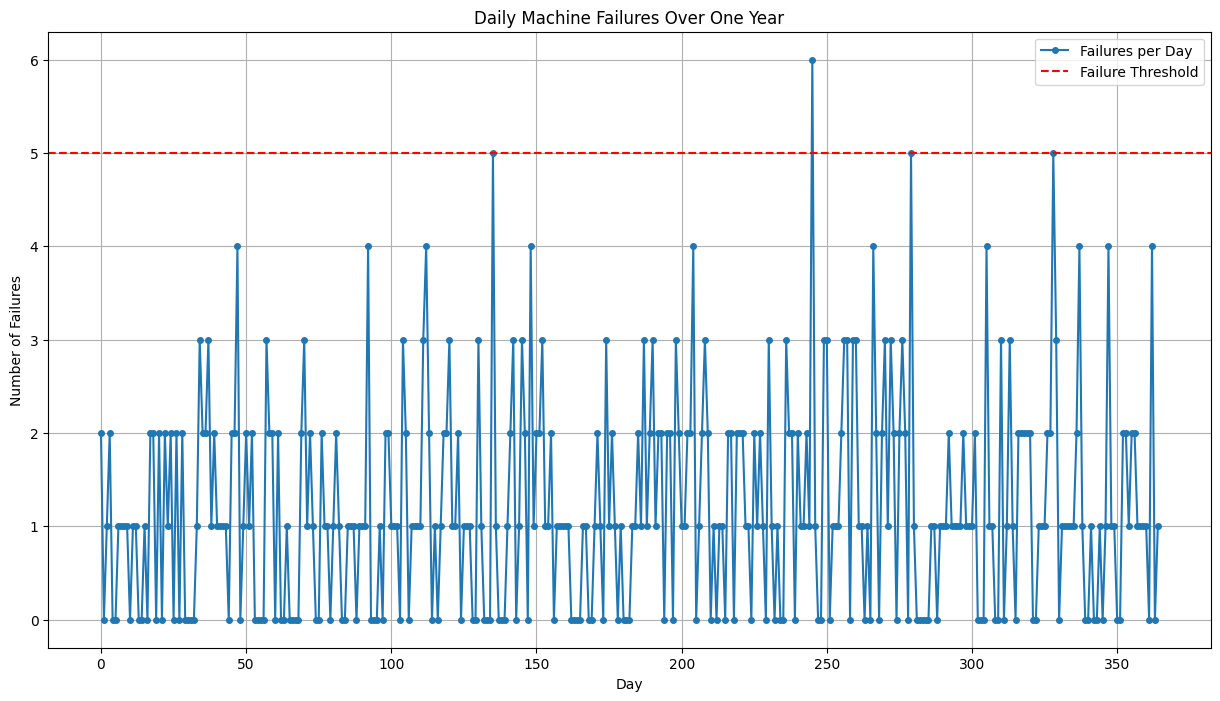

(0.010958904109589041, 4)

In [45]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(failures_distribution, label='Failures per Day', marker='o', linestyle='-', markersize=4)
plt.axhline(y=failure_threshold, color='r', linestyle='--', label='Failure Threshold')
plt.title('Daily Machine Failures Over One Year')
plt.xlabel('Day')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid(True)
plt.show()

probability_of_stop, days_stopped